In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Generate fake

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def normalize(x):
    # Normalize according to: Normalization
    x_min = x.min()
    x_max = x.max()
    
    if (x_max -x_min) == 0:
         x = np.zeros_like(x)
    else:
        x = (x-x_min)/(x_max -x_min)
    return x


In [10]:


def normalize(x):
    # Normalize according to: Standardizatio
    # https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/
    x_mean = x.mean()
    x_std = x.std()
    
    if x_std == 0:
        x = np.zeros_like(x)
    else:
        x = (x-x_mean)/(x_std)
    return x

def plot_example(select_samples, fail=1):
    sample_from = random.randint(min(data_info[f"index_{fail}"]), max(data_info[f"index_{fail}"])-select_samples)
    fig, ax = plt.subplots(select_samples,1,figsize=(6,6))
    for i,j in enumerate(range(sample_from, sample_from+select_samples)):

        ax[i].plot(data[j][0].T)
    plt.show()


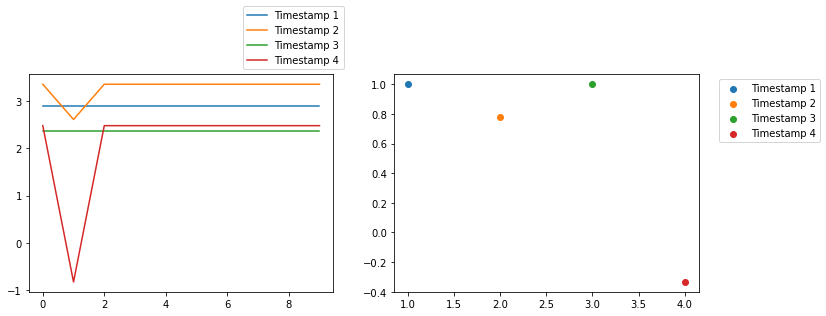

In [11]:
time_steps = 5
n_cells = 10 # Amount of cells in pack
x = np.zeros([time_steps,n_cells])


fig, ax = plt.subplots(1,2,figsize=(12,4))

failed_cell = 1 # Which cell is the failing cell
is_fail = True# Does the pack include a failed cell
volt_stochastic = 0.5
for i in range(1,time_steps):
    sigma = 0.0 # How much is the fluctuation
    median = random.uniform(2, 4)
    volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
    y = 1
    if is_fail:
        r = random.random()
        if r < volt_stochastic:
            stochstic_amplifier = random.randint(1,10)
            
            y = (1-i/stochstic_amplifier)
            #print(y)
            volt[failed_cell]*=y
    ax[1].scatter(i,y,label=f"Timestamp {i}")
    ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax[1] = plt.gca()
    #ax[1].set_ylim(ax[1].get_ylim()[::-1])
    x[i,:] = volt
            
    ax[0].plot(volt,label=f"Timestamp {i}")
    ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='lower right')
#plt.ylim(0,16)
#plt.legend()



#plt.scatter(x_arr, y_arr)
#ax = plt.gca()
#ax.set_ylim(ax.get_ylim()[::-1])

In [12]:
def create_sequence(time_steps=2, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=False):
    x = np.zeros([time_steps,n_cells])
    for i in range(0,time_steps):
        median = random.uniform(2, 4)
        volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
        if is_fail:
            r = random.random()
            if r < volt_stochastic:
                stochstic_amplifier = random.randint(1,10) # 100, 1000

                y = (1-(i+1)/stochstic_amplifier)
                #print(y)
                volt[failed_cell]*=y
        x[i,:] = volt
    if normalize_x:
        x_norm = np.zeros_like(x)
        for i in range(len(x)):
            x_norm[i,:] = normalize(x[i,:])
        #x = normalize(x)
        x = x_norm
    if is_fail:
        label = 1
    else:
        label = 0
    return x, label
    

In [13]:
time_steps=20 
n_cells=108
failed_cell=1 
sigma=0
volt_stochastic = 0.5
normalize_x=True

def create_data(n_healthy=2, n_fails=2,time_steps=time_steps, random_cell_fail=False, failed_cell=3,sigma=sigma, volt_stochastic=volt_stochastic, n_cells=n_cells):
    data = []
    
    data_info ={"index_1":[],
           "index_0": []} 
    for i in range(n_healthy+n_fails):
        if i >= n_healthy:
            fail=True
        else:
            fail=False
        if random_cell_fail:
            failed_cell = random.randint(0,n_cells-1)
        #else:
            #continue

        x,y = create_sequence(time_steps=time_steps, n_cells=n_cells, failed_cell=failed_cell, is_fail=fail, sigma=sigma, volt_stochastic=volt_stochastic, normalize_x=normalize_x)
        data.append((torch.FloatTensor(x),y))
        
        #Finn data_info
        if y == 1:
            data_info["index_1"].append(i)
            
        if y == 0:
            data_info["index_0"].append(i)
            
    return (data, data_info)
    

data, data_info = create_data(n_healthy=1000, n_fails=1000,random_cell_fail=False, failed_cell=3)

## plot n random samples from failed

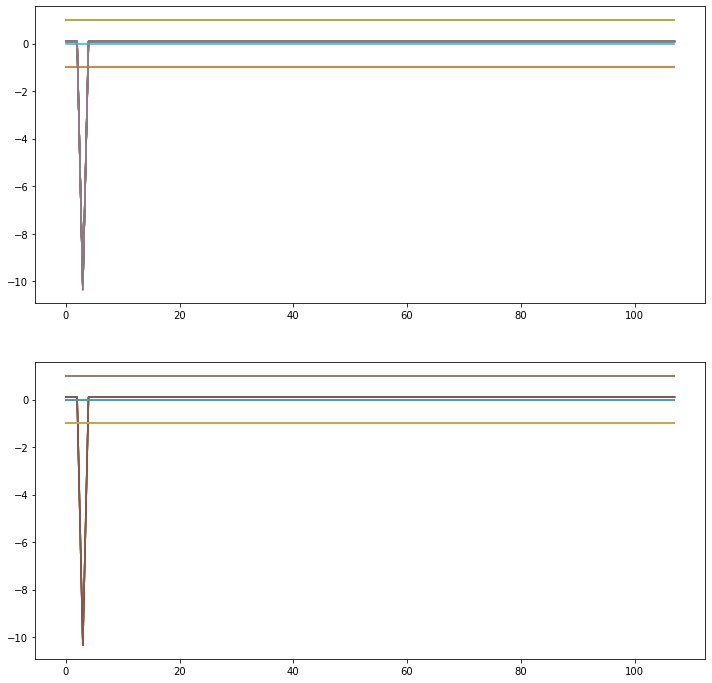

In [14]:
select_samples = 2
sample_from = random.randint(min(data_info["index_1"]), max(data_info["index_1"])-select_samples)
fig, ax = plt.subplots(select_samples,1,figsize=(12,12))
for i,j in enumerate(range(sample_from, sample_from+select_samples)):

    ax[i].plot(data[j][0].T)
plt.show()

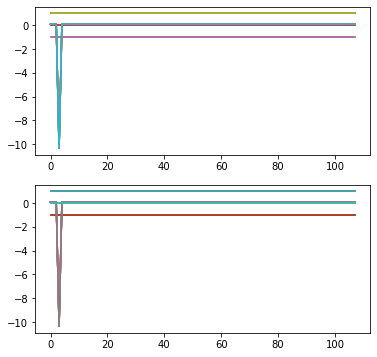

In [15]:
plot_example(select_samples=2, fail=1)

## Create dataset

In [16]:
from numpy.random import seed
seed(101)

In [38]:
time_steps=3
n_cells=108
failed_cell=50 
sigma=0.0
volt_stochastic = 0.9
normalize_x=False
random_cell_fail=False
n_healthy = 1000
n_fails = 100

data, data_info = create_data(n_healthy=n_healthy, n_fails=n_fails, time_steps=time_steps, random_cell_fail=random_cell_fail, failed_cell=failed_cell,sigma=sigma, volt_stochastic=volt_stochastic, n_cells=n_cells)

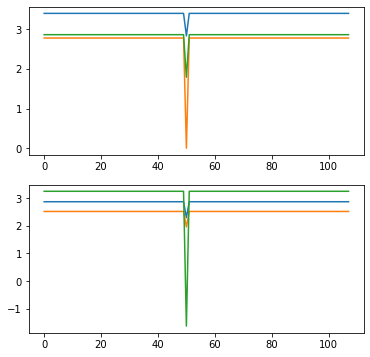

In [39]:
plot_example(select_samples=2, fail=1)

In [40]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data,[train_size, test_size])
batch_size = 10
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,drop_last=True)

In [41]:
for (X_train, y_train) in train_loader:
    break

In [42]:
X_train.shape

torch.Size([10, 3, 108])

In [43]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
test_loader_all = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=True,drop_last=True)
train_loader_all = DataLoader(dataset=train_set, batch_size=len(train_set), shuffle=True,drop_last=True)
for x_test, y_test in test_loader_all:
    break
for x_train, y_train in train_loader_all:
    break
x_test = x_test.numpy().reshape(len(test_set),-1)/x_test.max()
y_test = y_test.numpy().reshape(len(test_set),-1)
x_train = x_train.numpy().reshape(len(train_set),-1)
y_train = y_train.numpy().reshape(len(train_set),-1)
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(220, 324)
(220, 1)
(880, 324)
(880, 1)


In [52]:
x_test.max()

3.9998531341552734

In [45]:
#x_test = x_test.reshape(len(test_set),batch_size*n_cells)
x_test = x_test.reshape(len(test_set),-1)
y_test = y_test.reshape(1,-1)
x_test = np.array(x_train.tolist())
y_test = np.array(y_train.tolist())

x_train = x_test.reshape(len(train_set),-1)
y_train = y_test.reshape(len(train_set),-1)
x_train = np.array(x_train.tolist())
y_train = np.array(y_train.tolist())

print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(880, 324)
(880, 1)
(880, 324)
(880, 1)


In [46]:
class Autoencoder(keras.Model):
    def __init__(self, bottle_neck):
        super(Autoencoder, self).__init__()
        self.bottle_neck = bottle_neck
        
        glorot= tf.keras.initializers.GlorotUniform()
        # Encoder
        self.encoder = Sequential([Input(batch_size*n_cells),
                                   Dense(150, kernel_initializer=glorot, activation="relu"), # Layer 2
                                  Dense(self.bottle_neck, kernel_initializer=glorot, activation="relu")]) # Layer 3
        # Decoder
        self.decoder = Sequential([Dense(batch_size*n_cells, kernel_initializer=glorot, activation="relu")])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [47]:
# Initialize encoders
autoencoder1 = Autoencoder(2)
#autoencoder2 = Autoencoder(4)

# Compile encoders
adam = Adam(learning_rate=0.01)
autoencoder1.compile(optimizer=adam, loss="mse") #binary_crossentropy
#autoencoder2.compile(optimizer=adam, loss="mse")

In [48]:
x_train.shape

(880, 324)

In [49]:
# Fit encoders
epochs = 100
batch_size=10
autoencoder1.fit(x_train, x_train, epochs=epochs,batch_size=batch_size, shuffle=True,validation_data=(x_test, y_test))
#autoencoder2.fit(x_train, x_train, epochs=epochs,batch_size=batch_size, shuffle=True,validation_data=(x_test, y_test))

Epoch 1/100


ValueError: in user code:

    /Users/anderssegerlund/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /var/folders/jw/61jjk4jd69sbkflvlpjrlv1h0000gn/T/ipykernel_3210/2175316254.py:15 call  *
        encoded = self.encoder(x)
    /Users/anderssegerlund/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/anderssegerlund/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: expected axis -1 of input shape to have value 1080 but received input with shape (10, 324)


In [32]:
#List of index with number
index_list = [list(np.where(y_test==i))[0][0] for i in range(0,1)]

encoded_imgs = autoencoder1.encoder(x_test[index_list]).numpy()
decoded_imgs = autoencoder1.decoder(encoded_imgs).numpy().reshape([-1,batch_size*n_cells])



In [33]:
#encoded_imgs = autoencoder2.encoder(x_test[index_list]).numpy()
#decoded_imgs = autoencoder2.decoder(encoded_imgs).numpy().reshape([-1,batch_size*n_cells])

In [34]:
encode1 =autoencoder1.encoder(x_train)

In [35]:
n11 = np.array(encode1[:,0]).reshape(1,-1)[0]
n12 = np.array(encode1[:,1]).reshape(1,-1)[0]
#n11 = n11.reshape(-1,1)
#n12 = n12.reshape(-1,1)

In [36]:
Y_train = []
for i in y_train:
    Y_train.extend(i)
#y_train =np.array(Y_train)

<AxesSubplot:>

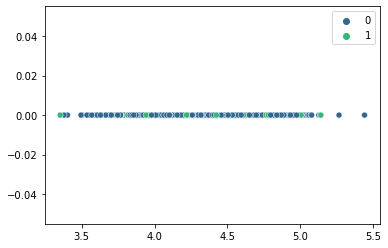

In [37]:
#sns.scatterplot(x=n11,y=n12,hue=y_train.reshape(1,-1)[0],palette="viridis")
sns.scatterplot(x=n11,y=n12,hue=y_test.reshape(1,-1)[0],palette="viridis")
#sns.scatterplot(x=n11,y=n12)